Imports


In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/Users/samir/Documents/GitHub/Google-Zero-Day-in-the-Wild-/0day _In the Wild_ - All.csv')

In [3]:
df.head()

,CVE,Vendor,Product,Type,Description,Date Discovered,Date Patched,Advisory,Analysis URL,Root Cause Analysis,Reported By
0,CVE-2024-23296,Apple,iOS,Memory Corruption,Arbitrary kernel r/w in RTKit,NaN,2024-03-06,https://support.apple.com/en-gb/HT214081,NaN,NaN,NaN
1,CVE-2024-23225,Apple,iOS,Memory Corruption,Out-of-bounds memory access in Kernel,NaN,2024-03-05,https://support.apple.com/en-gb/HT214081,NaN,NaN,NaN
2,CVE-2024-23222,Apple,WebKit,Memory Corruption,Type confusion,NaN,2024-01-22,https://support.apple.com/en-us/HT214059,NaN,NaN,NaN
3,CVE-2024-0519,Google,Chrome,Memory Corruption,Out-of-bounds memory access,2024-01-11,2024-01-16,https://chromereleases.googleblog.com/2024/01/...,NaN,NaN,NaN
4,CVE-2023-7024,Google,Chrome,Memory Corruption,Heap overflow in WebRTC,2023-12-19,2023-12-20,https://chromereleases.googleblog.com/2023/12/...,NaN,NaN,Clément Lecigne and Vlad Stolyarov of Google's...


Top 5 most Zero-Day according to Companies.

In [4]:
df['Date Patched'] = pd.to_datetime(df['Date Patched'])

In [5]:
df.isna().sum()
df.dropna(axis=1)
df.shape

(312, 11)

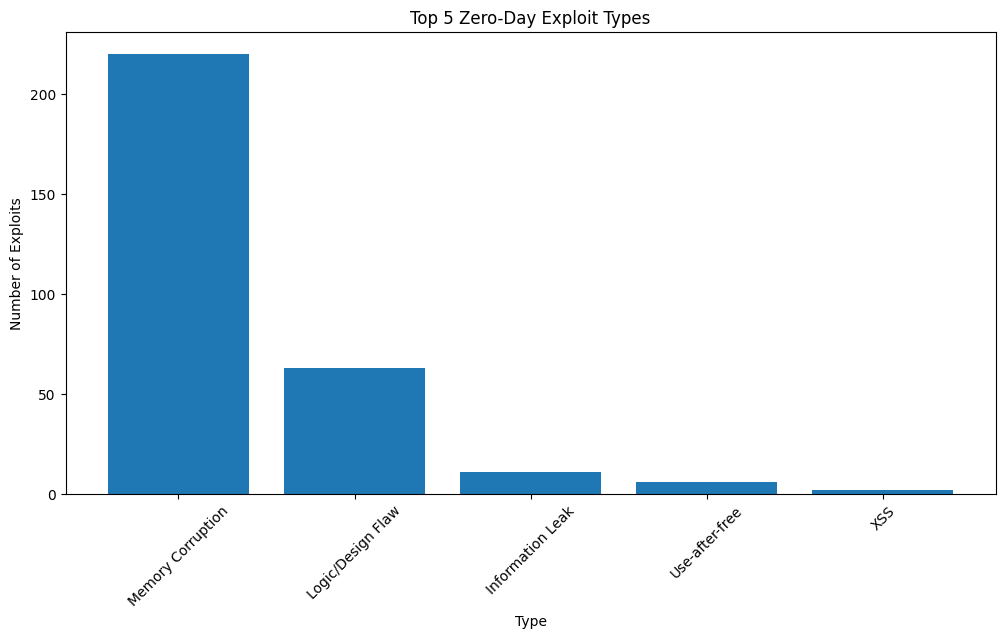

In [6]:

values = df['Type'].value_counts()
plt.figure(figsize=(12, 6))
plt.bar(values[:5].index, values[:5])
plt.xlabel('Type', loc='center')
plt.ylabel('Number of Exploits')
plt.xticks(rotation=45)
plt.title('Top 5 Zero-Day Exploit Types')
plt.show()

The types of Zero-Day Exploitation.

In [7]:
df['Type'].value_counts()


Type
Memory Corruption    220
Logic/Design Flaw     63
Information Leak      11
Use-after-free         6
XSS                    2
UXSS                   2
Info disclosure        1
Unspecified            1
Type Confusion         1
Race Condition         1
Name: count, dtype: int64

Classification based on the Exploitation type.


In [8]:
le = LabelEncoder()
for column in ['CVE', 'Type', 'Vendor', 'Product', 'Description', 'Date Patched', 'Advisory']:
    df[column] = le.fit_transform(df[column])


In [9]:
X = df[['CVE', 'Vendor', 'Product', 'Description', 'Date Discovered',
       'Date Patched', 'Advisory', 'Analysis URL', 'Root Cause Analysis']]
y = df['Type']

for column in ['Date Discovered','Analysis URL', 'Root Cause Analysis']:
  X[column] = le.fit_transform(X[column])

scaler = StandardScaler()
X = scaler.fit_transform(X)


/var/folders/89/xn87wdfs76x_gc0q1x5jl_4h0000gn/T/ipykernel_41906/3230545131.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
/var/folders/89/xn87wdfs76x_gc0q1x5jl_4h0000gn/T/ipykernel_41906/3230545131.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
/var/folders/89/xn87wdfs76x_gc0q1x5jl_4h0000gn/T/ipykernel_41906/3230545131.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
df['Type']

0      3
1      3
2      3
3      3
4      3
      ..
307    3
308    3
309    3
310    2
311    2
Name: Type, Length: 312, dtype: int64

Building the Model

In [11]:
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(len(y.unique()), activation='softmax')
])

/Users/samir/anaconda3/envs/tensorflow/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compiling the Model.

In [12]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)


Training the model

In [14]:
model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2)
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1304 - loss: 2.3703 - val_accuracy: 0.6600 - val_loss: 2.0400
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4335 - loss: 2.0235 - val_accuracy: 0.7200 - val_loss: 1.7089
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6061 - loss: 1.6799 - val_accuracy: 0.7200 - val_loss: 1.3815
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6960 - loss: 1.4010 - val_accuracy: 0.7200 - val_loss: 1.1273
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6732 - loss: 1.2489 - val_accuracy: 0.7200 - val_loss: 1.0085
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6628 - loss: 1.1736 - val_accuracy: 0.7200 - val_loss: 0.9739
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6889 - loss: 1.1235 - val_accuracy: 0.7200 - val_loss: 0.9665
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6921 - loss: 1.0952 - val_accuracy: 0.7200 - val_loss: 0.9680
Epoch 9

Making predictions

In [15]:
predictions = model.predict(X_test)
predicted_classes = tf.argmax(predictions, axis=1)

predicted_classes

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


<tf.Tensor: shape=(63,), dtype=int64, numpy=
array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])>

Confusion Matrix

In [16]:
conf_matrix = confusion_matrix(y_test, predicted_classes)
print(f'Confusion Matrix:\n{conf_matrix}')


Confusion Matrix:
[[ 0  0  3  0  0  0]
 [ 0  2 12  0  0  0]
 [ 0  0 42  0  0  0]
 [ 0  0  1  0  0  0]
 [ 0  0  2  0  0  0]
 [ 0  0  1  0  0  0]]


In [17]:
accuracy = accuracy_score(y_test, predicted_classes)
print(f'Accuracy: {accuracy}')

# Classification Report
class_report = classification_report(y_test, predicted_classes)
print(f'Classification Report:\n{class_report}')

Accuracy: 0.6984126984126984
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       1.00      0.14      0.25        14
           3       0.69      1.00      0.82        42
           5       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         1

    accuracy                           0.70        63
   macro avg       0.28      0.19      0.18        63
weighted avg       0.68      0.70      0.60        63



/Users/samir/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/samir/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/samir/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Plotting the Confusion Matrix

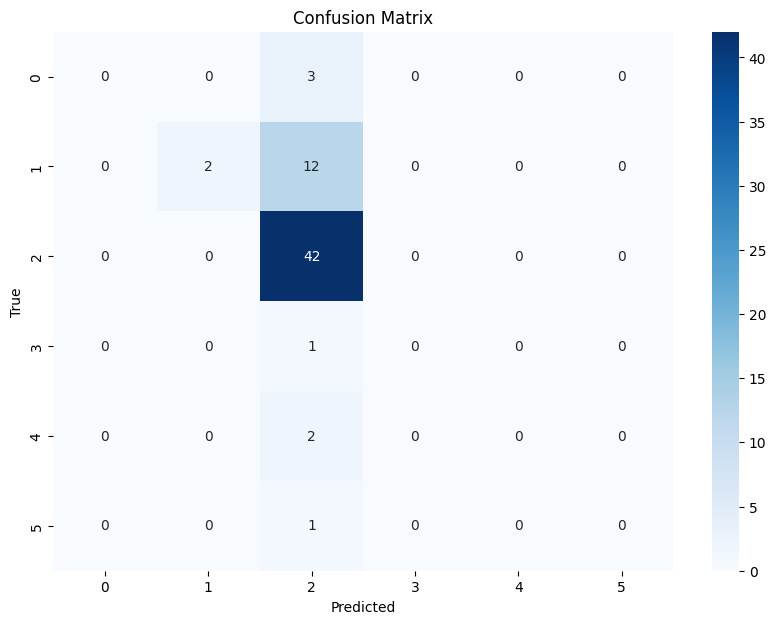

In [18]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
